We will make the basis model for our predictions to check against the actual model to see which one works best for our data

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import gmean
import scipy.stats as stats
import statsmodels.api as sm
from statistics import median, mean, stdev
import seaborn as sns
from scipy import stats 
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import math
from scipy.stats import gmean
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller,kpss
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [4]:
#!pip uninstall pandas
#!pip install --upgrade pandas==1.2.4
#!pip install --user  pandas

In [5]:
A = pd.read_csv('C:/Users/jlouv/ABA-Spring2023/Data/Pickle Files/Processed_Dataframes/Disease_Proc_df.csv')

In [6]:
A.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
# Create a dictionary to map column names to cancer types
column_map = {
    'CAN10_1': 'pharynx cancer',
    'CAN11_1': 'prostate cancer',
    'CAN5_1': 'breast cancer',
    'CAN6_1': 'cervix cancer',
    'CAN7_1': 'colon cancer',
    'CAN8_1': 'lung cancer',
    'CAN9_1': 'melanoma'
}

# Rename the columns using the column_map dictionary
A = A.rename(columns=column_map)

In [8]:
A

,State,StateDesc,Year,pharynx cancer,prostate cancer,breast cancer,cervix cancer,colon cancer,lung cancer,melanoma
0,AK,Alaska,2008,11.500000,108.950000,124.350000,7.300000,42.100000,59.300000,12.700000
1,AK,Alaska,2009,11.625000,104.125000,123.925000,7.125000,42.050000,58.275000,13.050000
2,AK,Alaska,2010,11.616667,99.566667,124.733333,6.833333,41.650000,57.283333,13.466667
3,AK,Alaska,2011,11.637500,94.937500,125.225000,6.875000,41.350000,56.562500,13.637500
4,AK,Alaska,2012,11.620000,92.220000,125.000000,6.950000,41.110000,55.990000,13.840000
...,...,...,...,...,...,...,...,...,...,...
619,WY,Wyoming,2015,11.080000,119.840000,123.400000,7.060000,35.360000,46.700000,24.890000
620,WY,Wyoming,2016,11.212500,121.737500,123.837500,7.075000,35.450000,46.587500,25.200000
621,WY,Wyoming,2017,11.416667,125.483333,124.333333,7.450000,35.633333,46.333333,25.700000
622,WY,Wyoming,2018,11.475000,128.225000,125.150000,7.900000,36.150000,46.475000,26.325000


We will be exploring 3 states to take an accuracy measure and use it that as the basis

In [9]:
# necessary changes for the subsets to be used for the prediction part

cal1 = A[(A['State'] == 'CA')]
tex1 =  A[(A['State'] == 'TX') ]
ny1=   A[(A['State'] == 'NY')]

ny1.reset_index(inplace = True)
cal1.reset_index(inplace = True)
tex1.reset_index(inplace = True)

ny1.set_index('Year', inplace = True)
cal1.set_index('Year', inplace = True)
tex1.set_index('Year', inplace = True)
              

ny1.drop(['index', 'State',  'StateDesc'], axis = 1, inplace = True)
cal1.drop(['index', 'State',  'StateDesc'],axis = 1, inplace = True)
tex1.drop(['index', 'State',  'StateDesc'],axis = 1, inplace = True)

In [10]:
# subset of the data to be used as the historical observations for the model fit

cal = cal1[:-4]
tex = tex1[:-4]
ny = ny1[:-4]

In [11]:
cal1

,pharynx cancer,prostate cancer,breast cancer,cervix cancer,colon cancer,lung cancer,melanoma
Year,,,,,,,
2008,10.450000,119.550000,125.950000,7.750000,39.600000,47.350000,19.800000
2009,10.450000,116.175000,126.000000,7.650000,38.925000,46.800000,19.900000
2010,10.483333,112.416667,126.016667,7.566667,38.433333,46.183333,20.133333
2011,10.525000,108.812500,126.387500,7.500000,38.037500,45.662500,20.387500
2012,10.560000,105.380000,126.610000,7.470000,37.720000,45.230000,20.620000
2013,10.610000,99.530000,127.020000,7.380000,37.000000,44.310000,21.020000
2014,10.650000,94.830000,127.450000,7.330000,36.500000,43.440000,21.410000
2015,10.670000,92.110000,128.110000,7.310000,36.080000,42.670000,21.670000
2016,10.675000,90.637500,128.262500,7.312500,35.887500,42.312500,21.800000


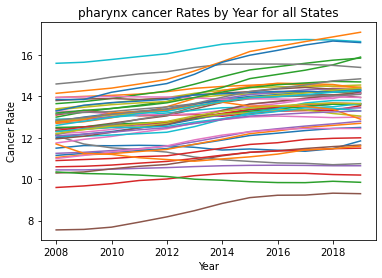

In [12]:
#just to get an idea for the data and how it looks (at least for one of the cancers)

# group the data by state
state_groups = A.groupby('State')

# plot each state's cancer rates over time
for state, group in state_groups:
    plt.plot(group['Year'], group['pharynx cancer'], label=state)
    #plot_acf(group['CAN10_1'], label = state)
    #plot_pacf(group['CAN10_1'].squeeze(), lags = 5, title = state)

# add plot title and axis labels
plt.title('pharynx cancer Rates by Year for all States')
plt.xlabel('Year')
plt.ylabel('Cancer Rate')
#plt.legend()

plt.show()

As a first glance there appears to be some trend that needs to be managed (differencing maybe)

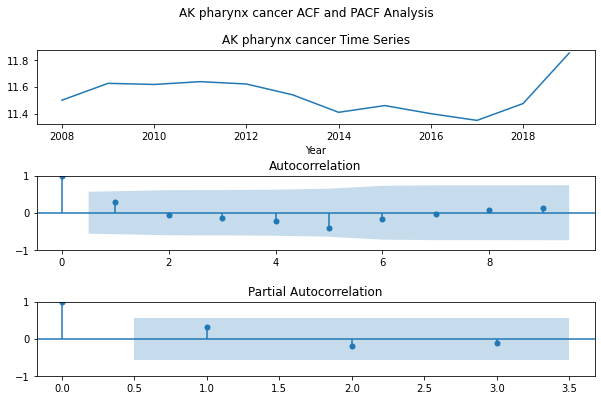

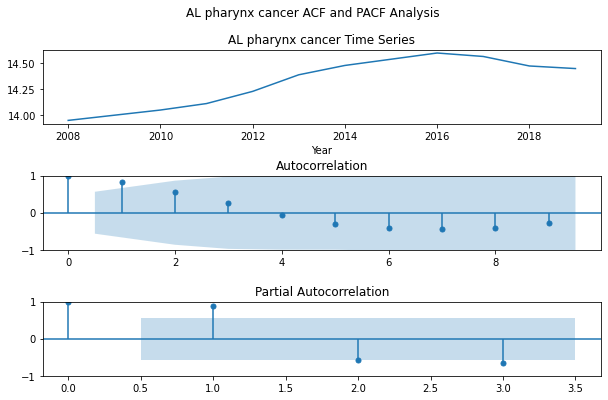

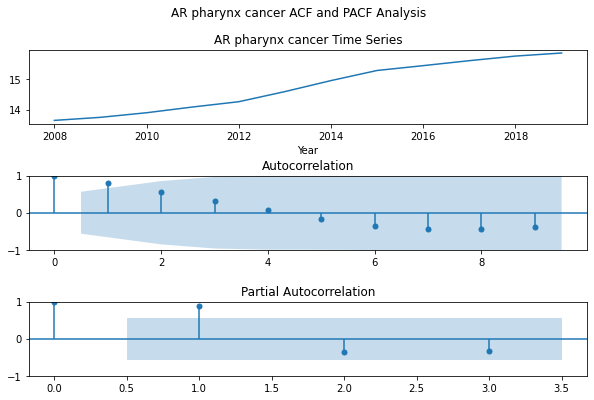

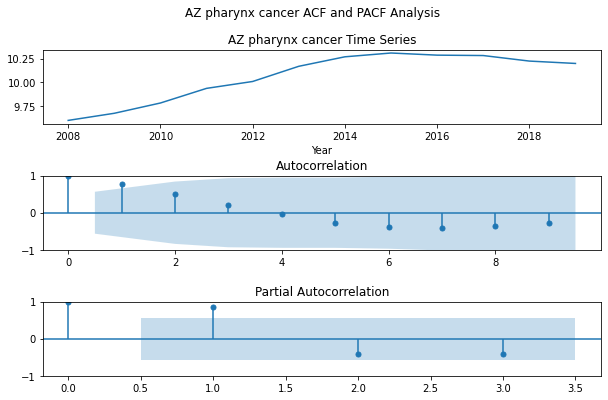

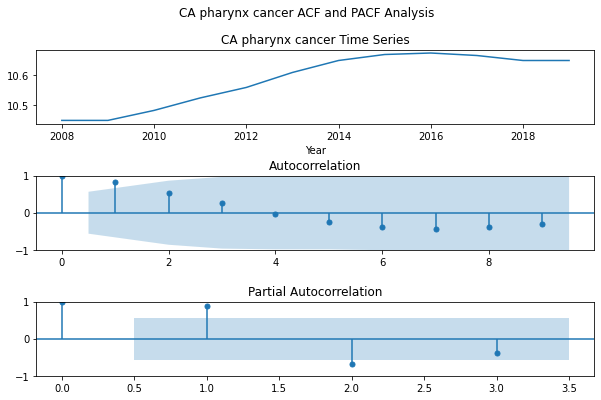

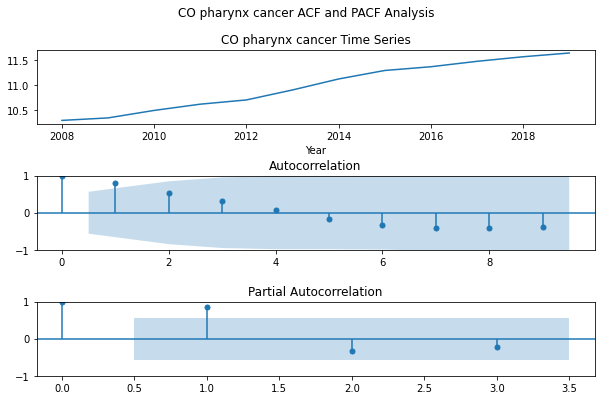

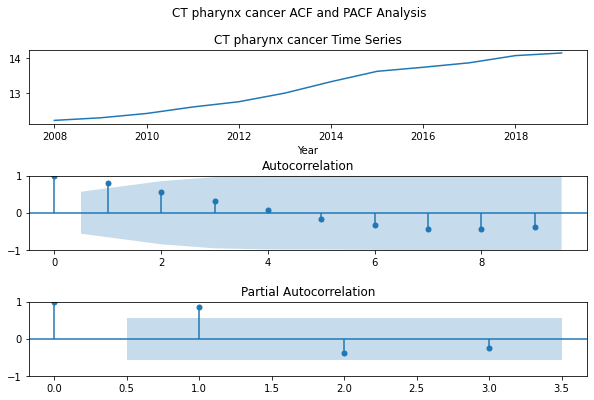

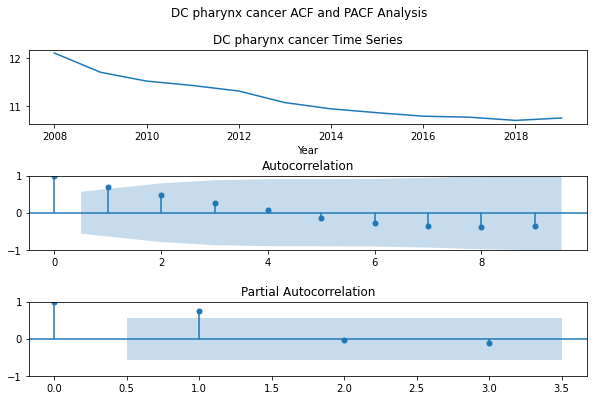

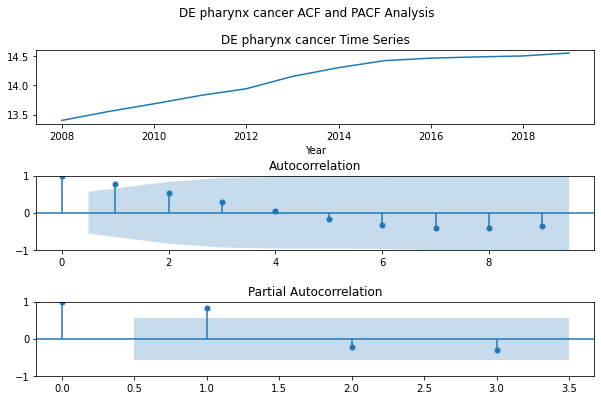

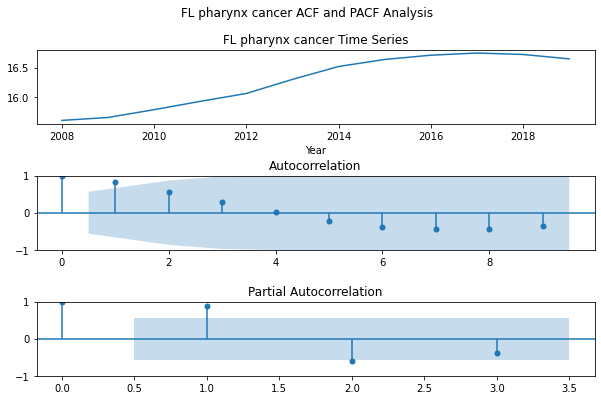

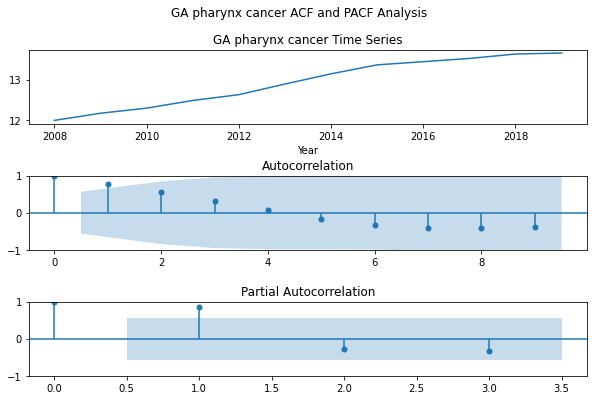

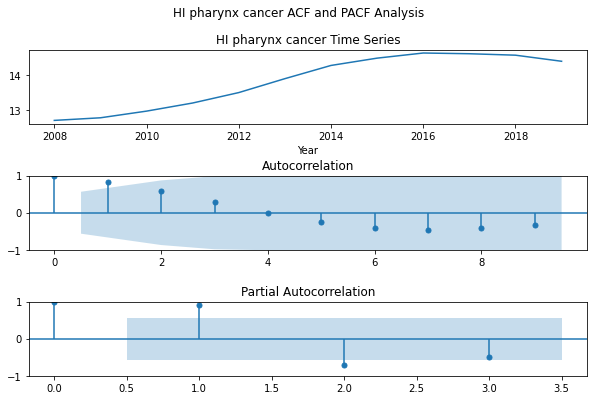

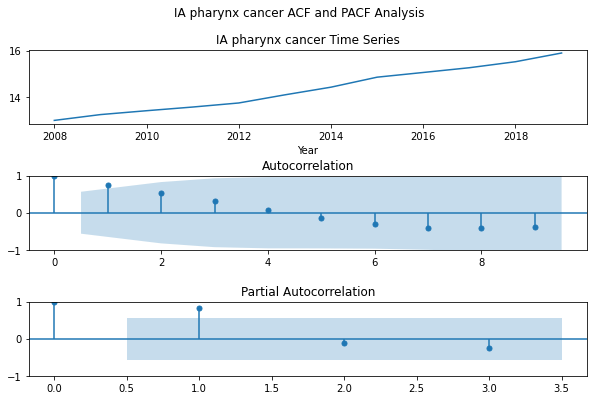

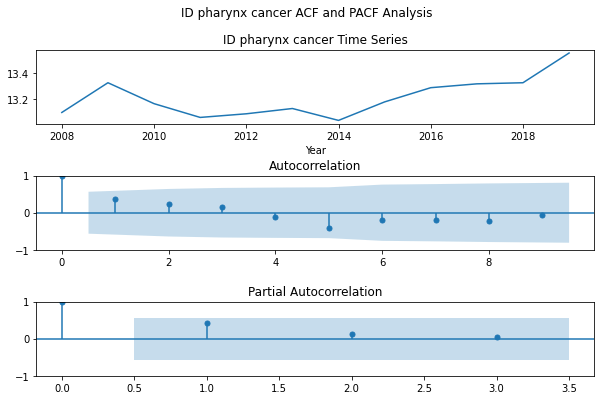

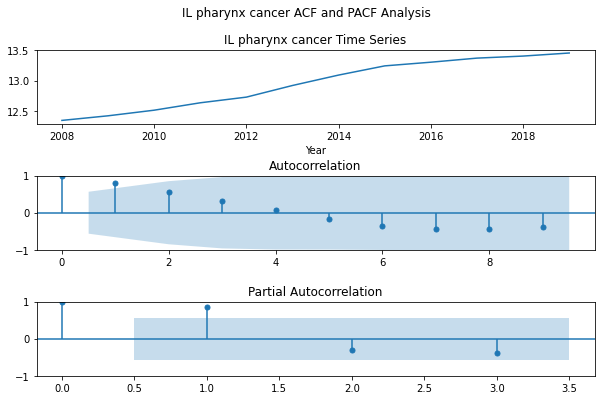

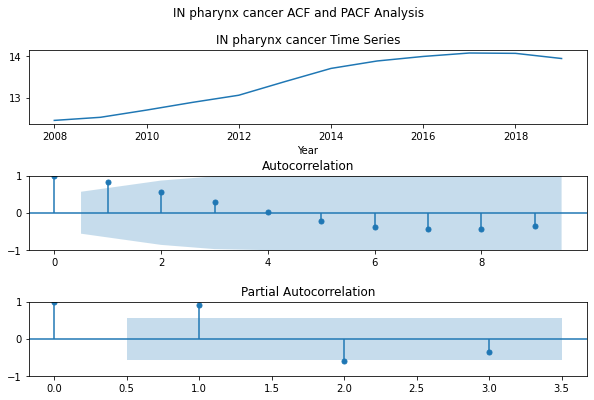

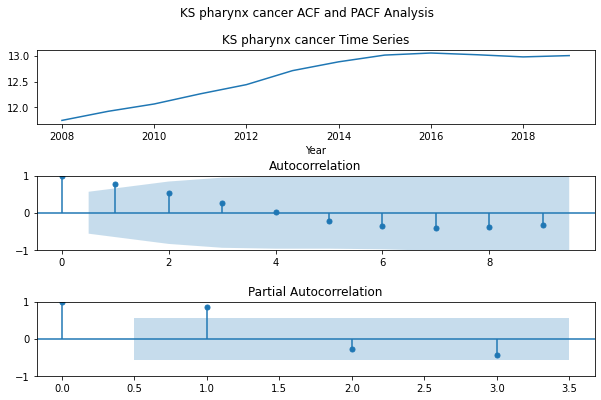

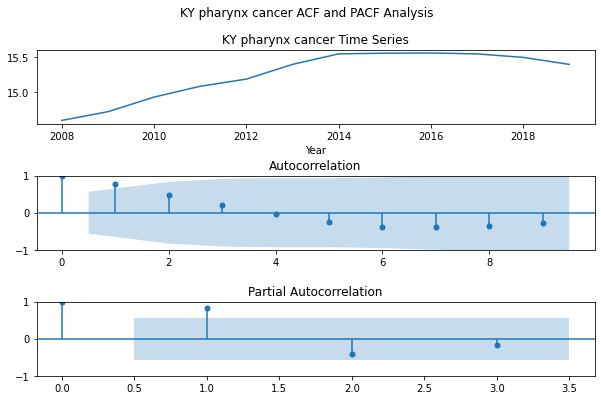

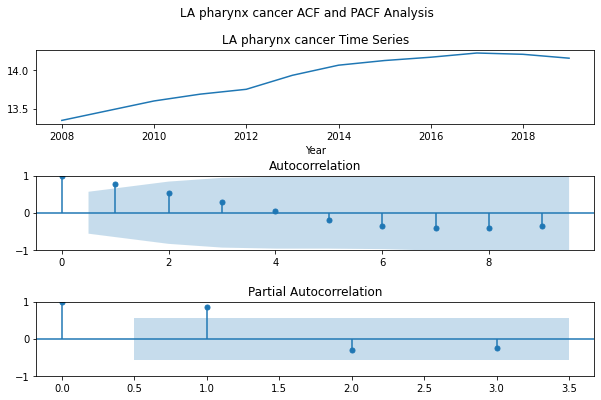

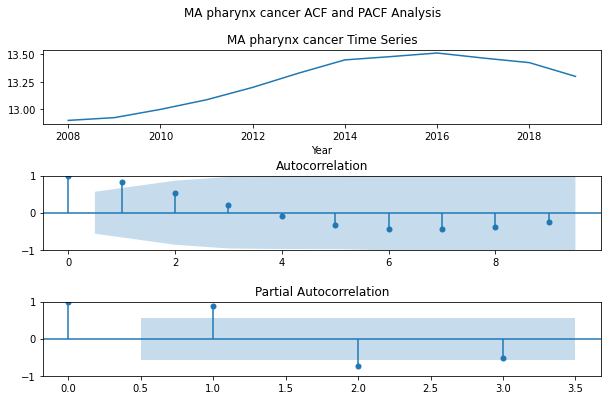

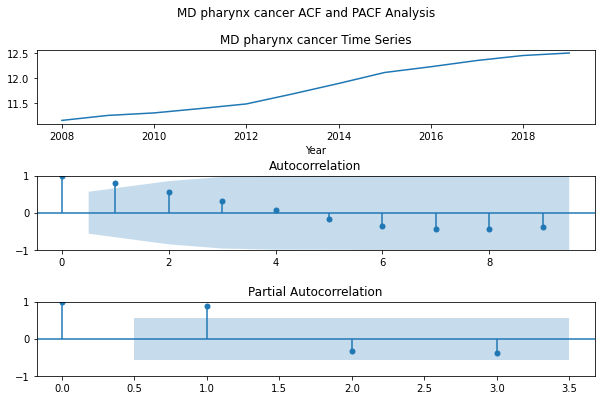

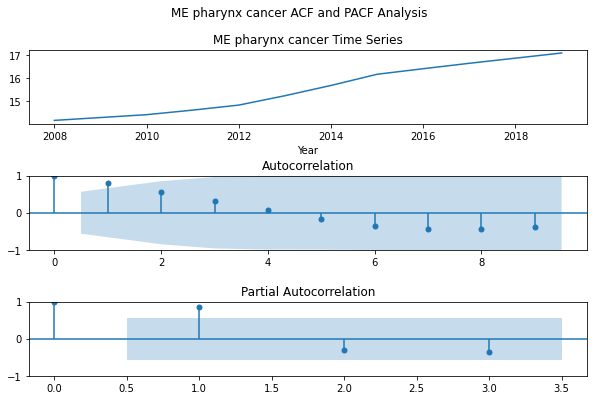

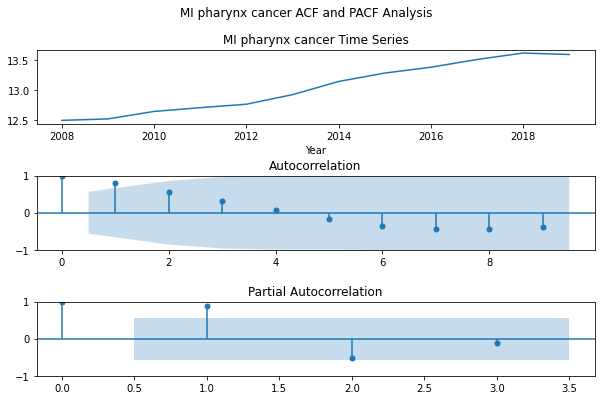

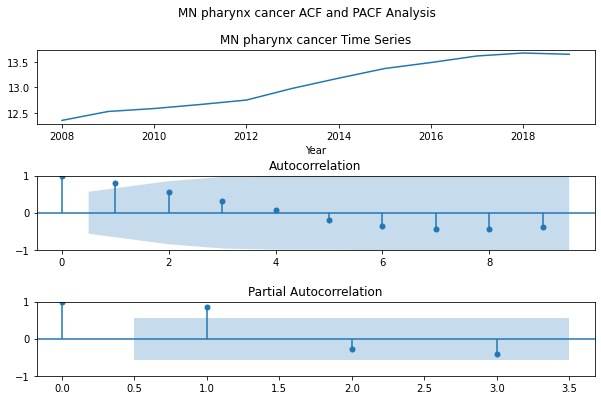

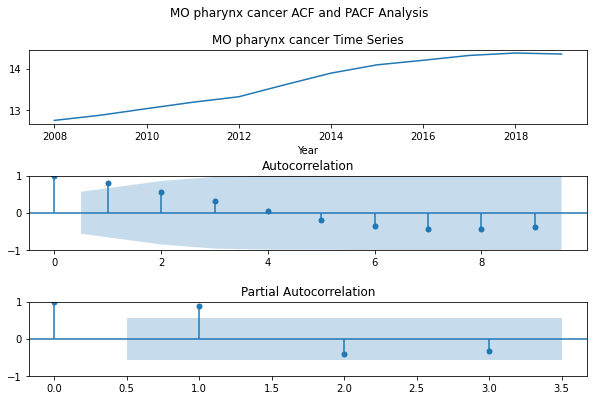

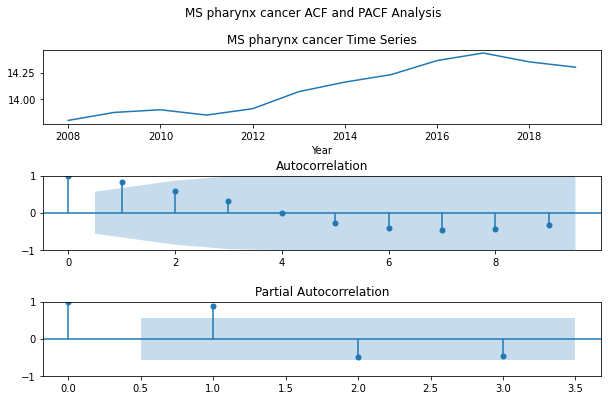

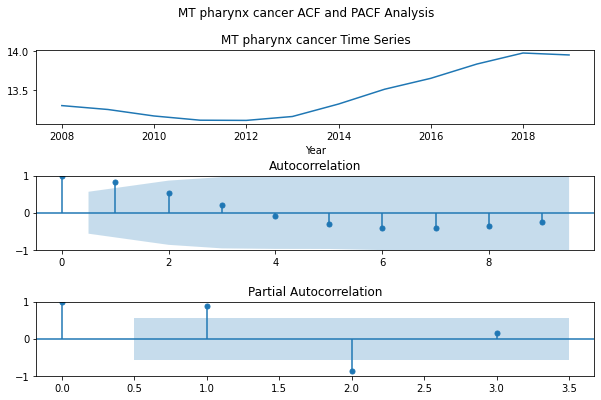

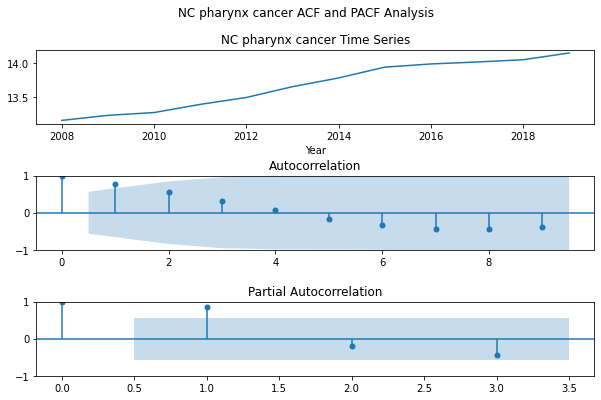

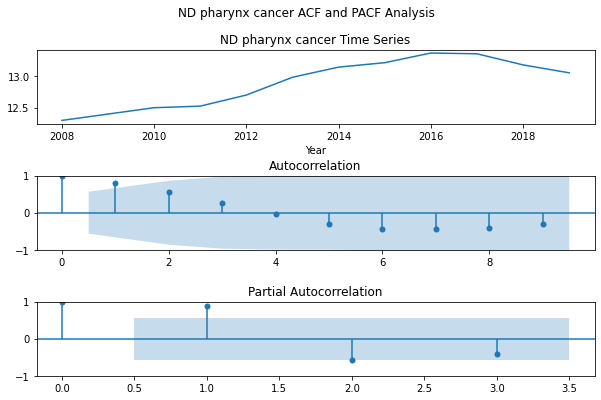

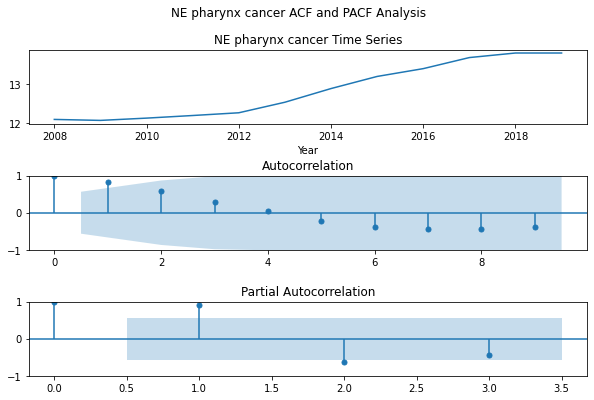

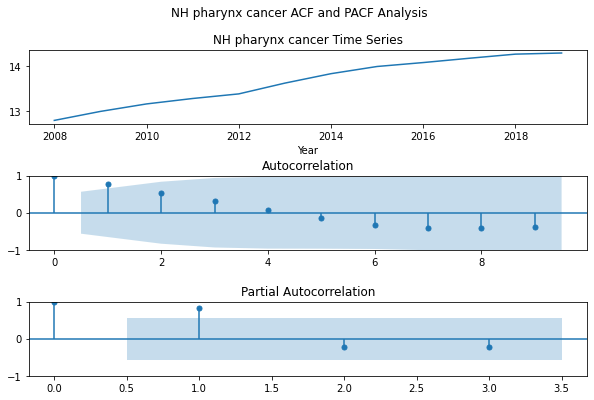

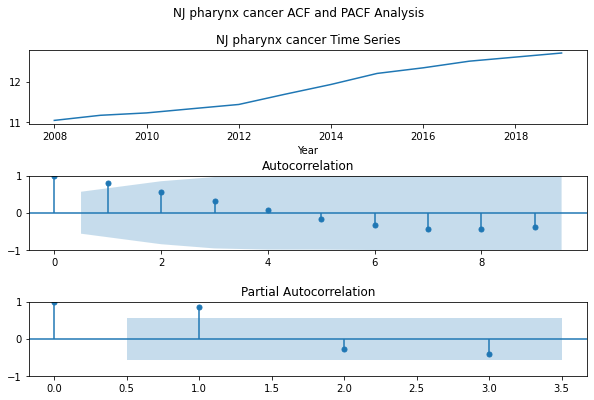

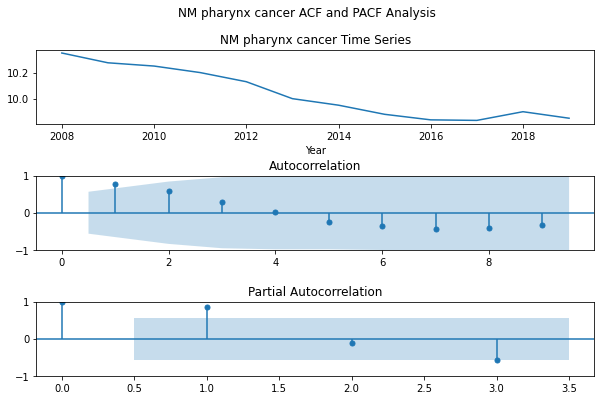

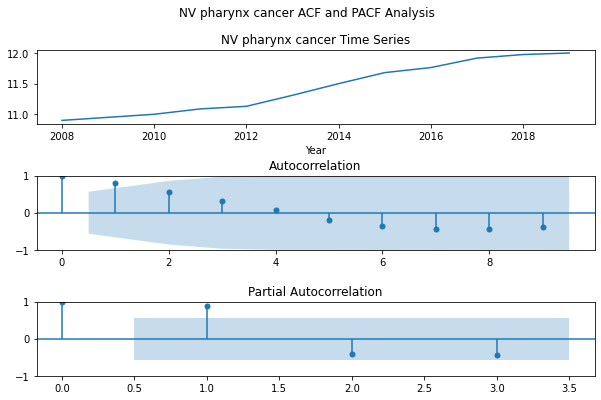

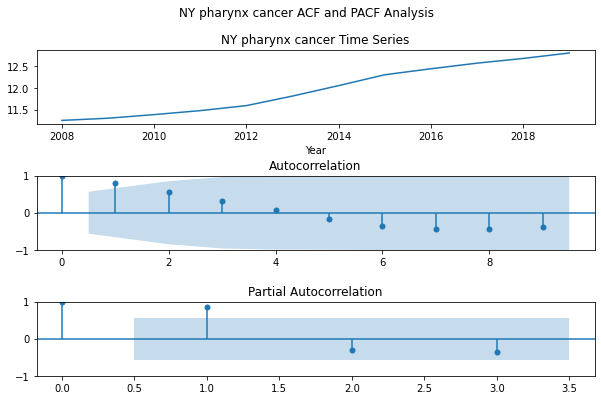

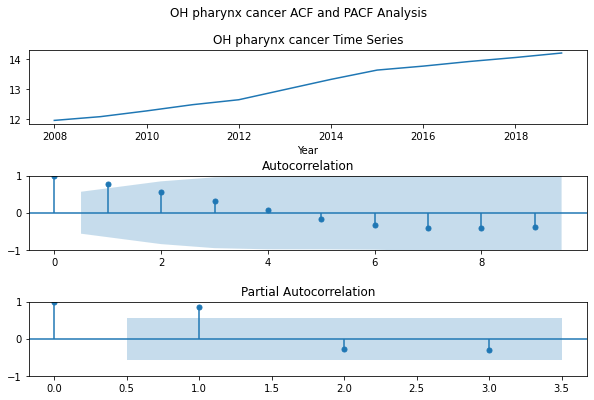

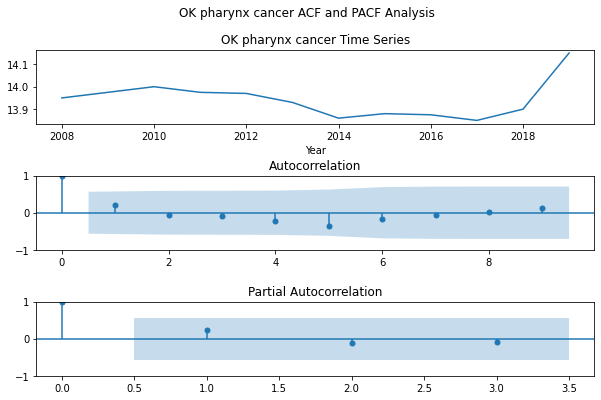

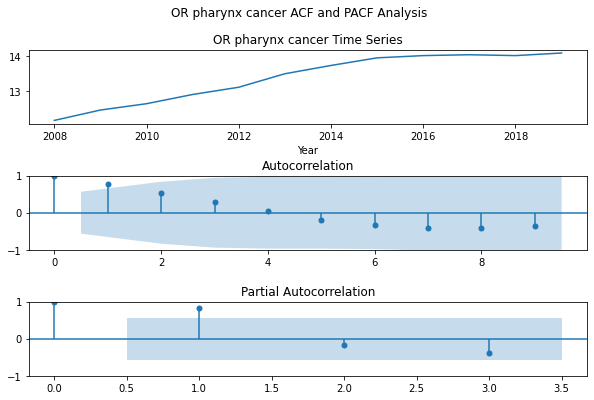

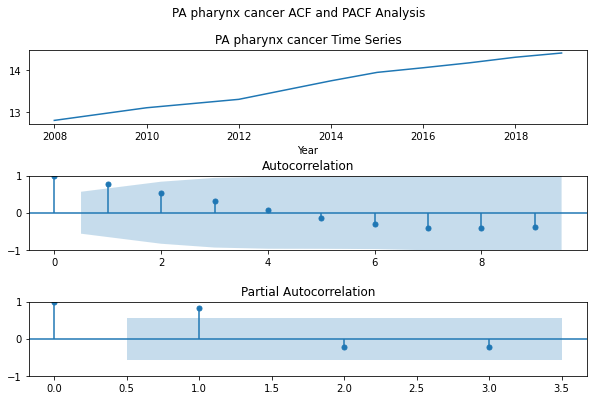

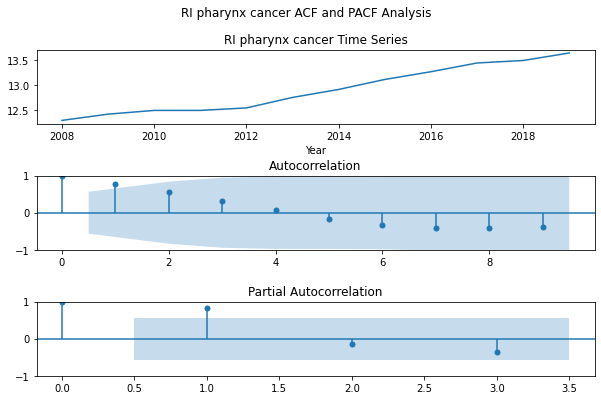

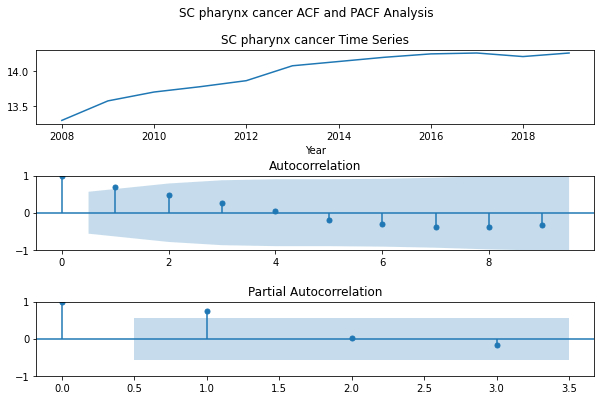

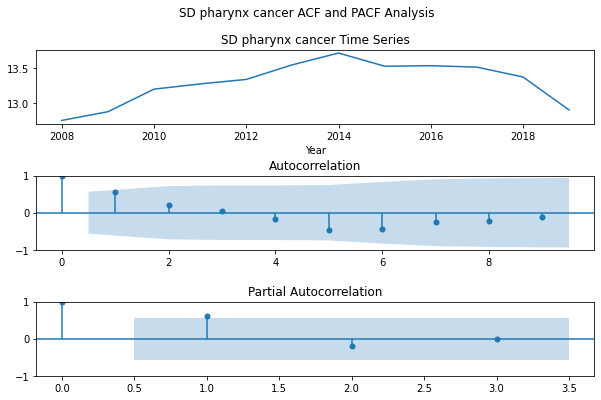

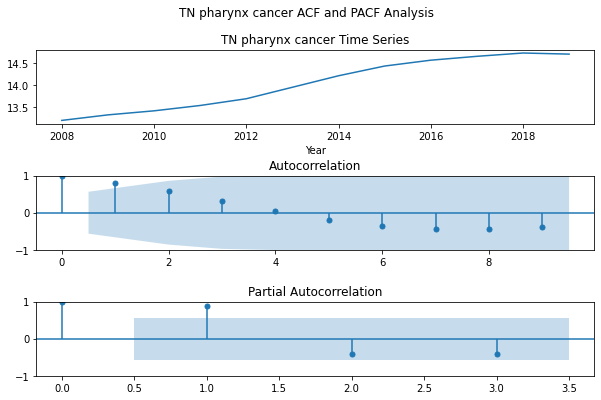

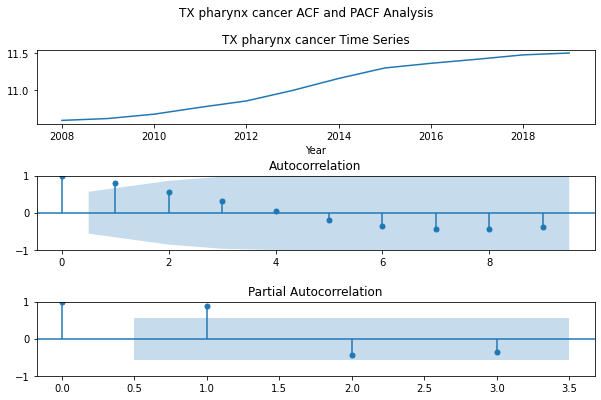

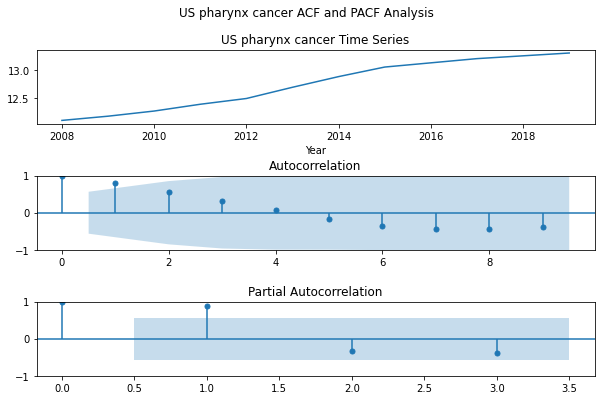

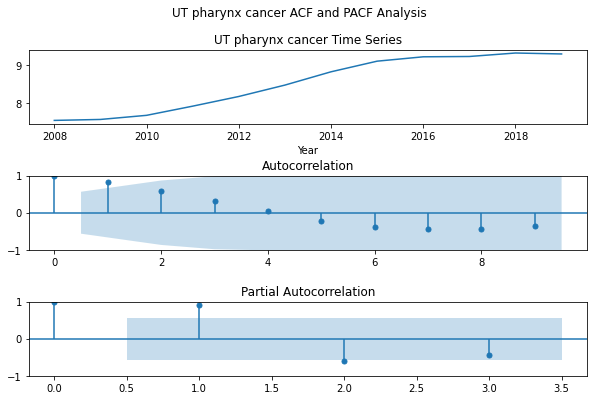

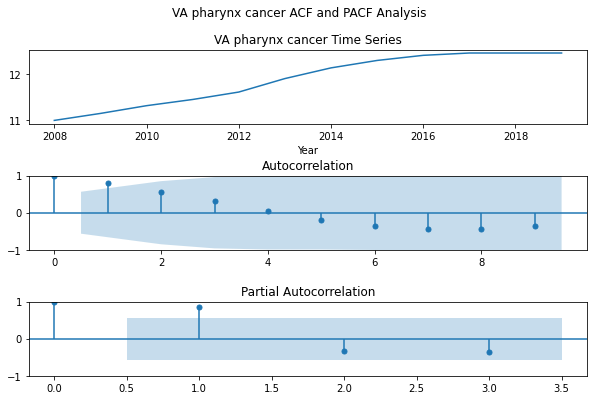

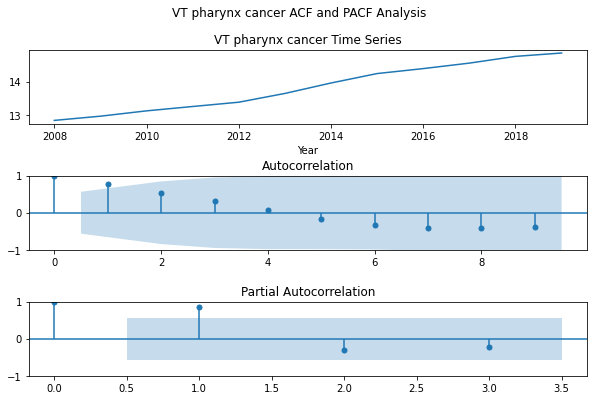

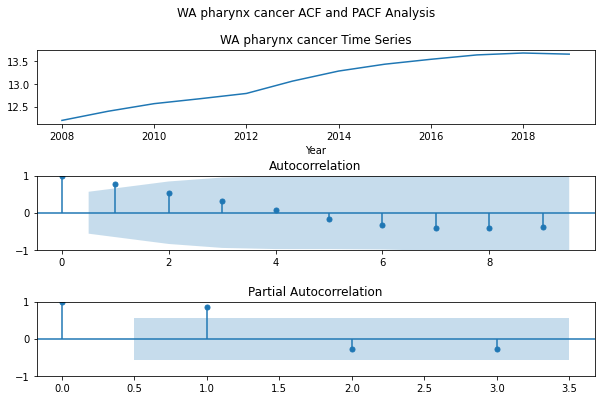

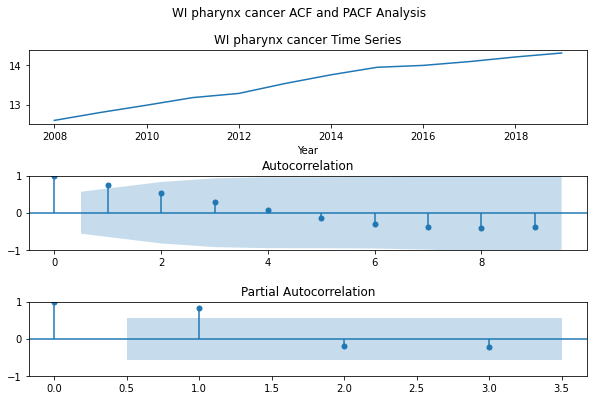

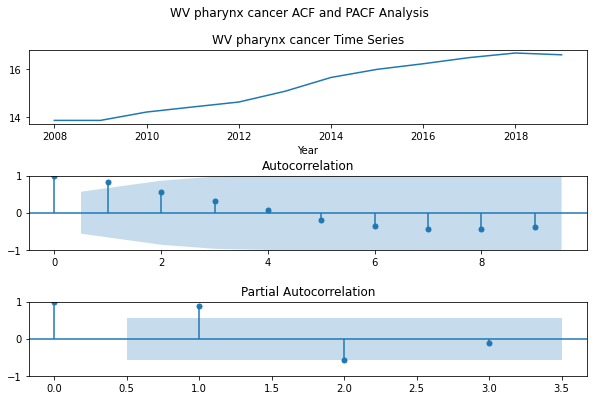

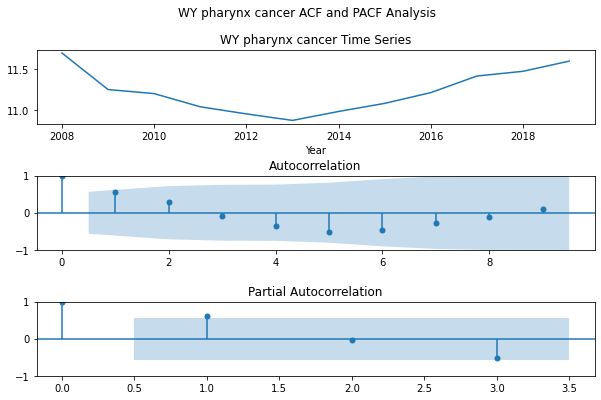

In [13]:
# Pivot the dataframe to have 'Year' as columns and 'State' as rows
df_pivot = A.pivot(index='State', columns='Year', values='pharynx cancer')

# Loop over each state
for state in df_pivot.index:
    # Get the time series for the state
    ts = df_pivot.loc[state].dropna()
    # Perform ACF and PACF analysis
    fig, axes = plt.subplots(3, 1, figsize=(10, 6))
    ts.plot(ax=axes[0])
    axes[0].set_title(f"{state} pharynx cancer Time Series")
    sm.graphics.tsa.plot_acf(ts, lags=9, ax=axes[1])
    sm.graphics.tsa.plot_pacf(ts, lags=3, ax=axes[2])
    fig.suptitle(f"{state} pharynx cancer ACF and PACF Analysis")
    fig.subplots_adjust(hspace=0.7)
    plt.show()


after a better look for each one seems to confirm that trend exists in almost all of the states

In [14]:
cal.columns

Index(['pharynx cancer', 'prostate cancer', 'breast cancer', 'cervix cancer',
       'colon cancer', 'lung cancer', 'melanoma'],
      dtype='object')

We will check on the three states we chose to see their plot and acf and pacf plot

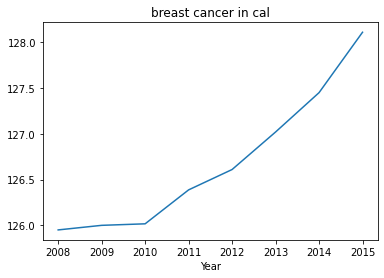

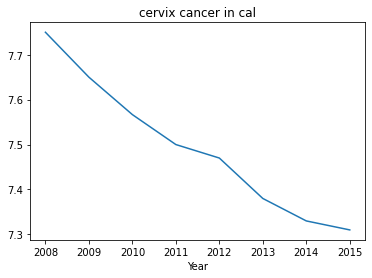

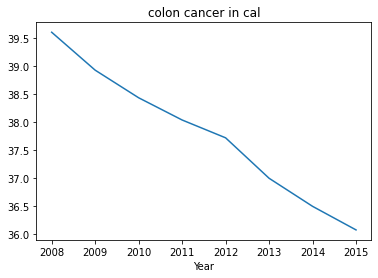

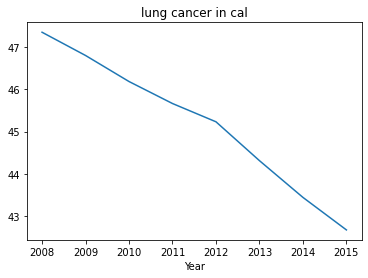

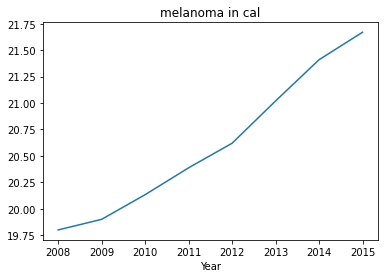

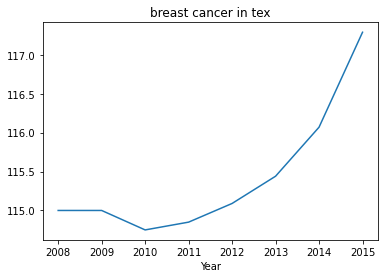

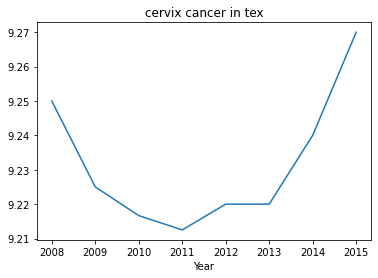

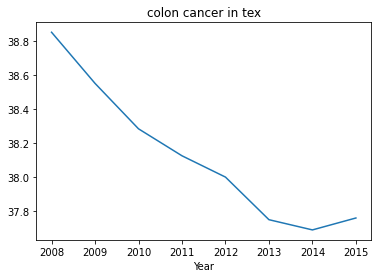

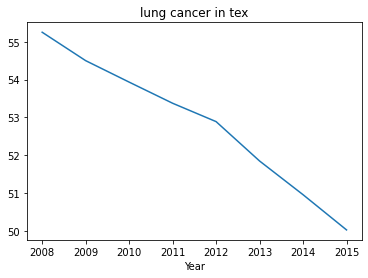

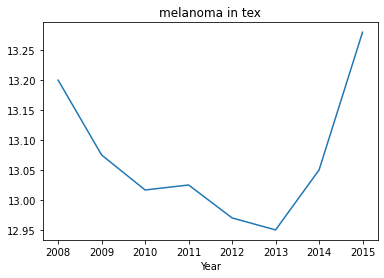

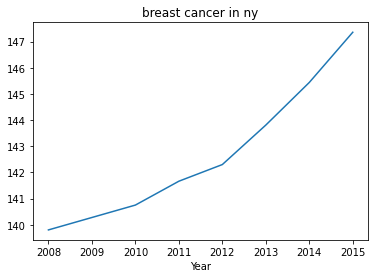

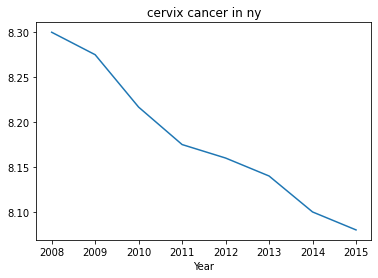

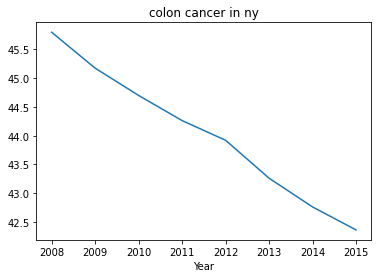

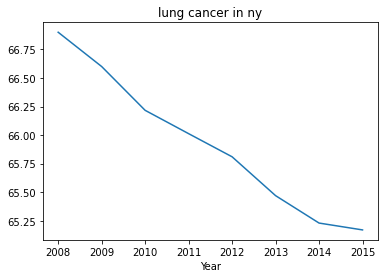

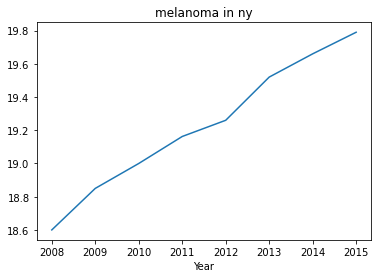

In [15]:
# Loop over each dataframe
for df, state in zip ([cal, tex, ny],['cal', 'tex', 'ny']):
    # Loop over each cancer type
    for col in df.columns[2:]:
        cancer_type = col.split('_')[0]
        ts = df[col]
        ts.plot()
        plt.title(f"{cancer_type} in {state}")
        plt.show()


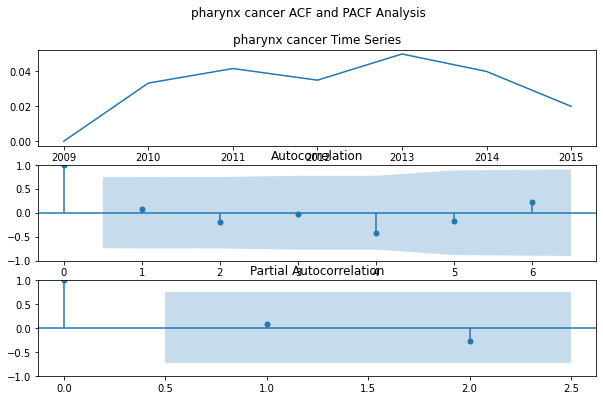

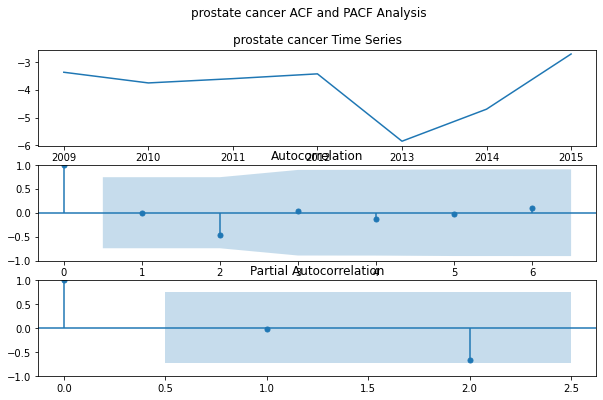

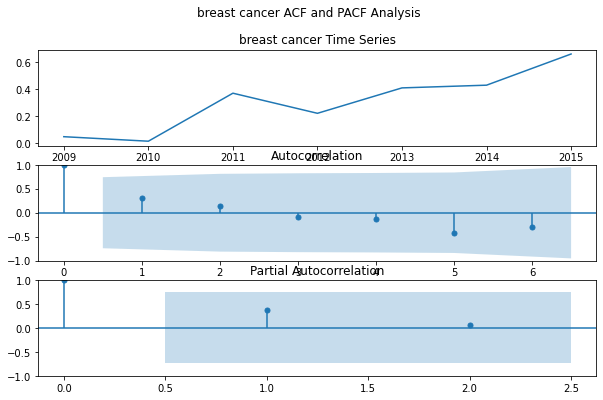

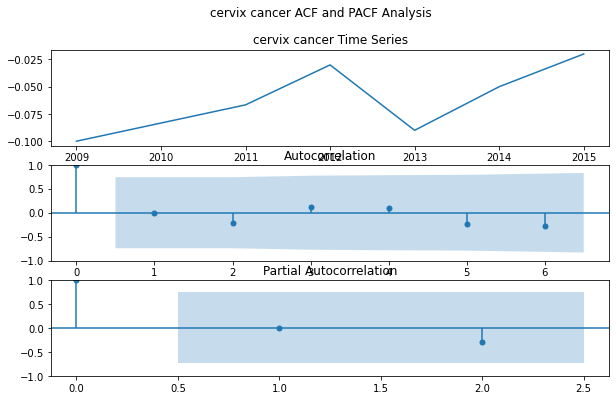

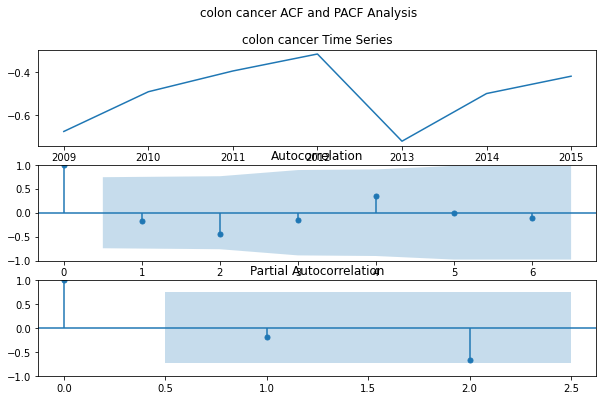

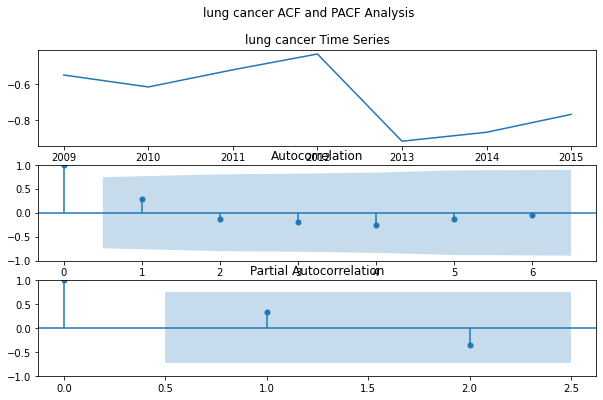

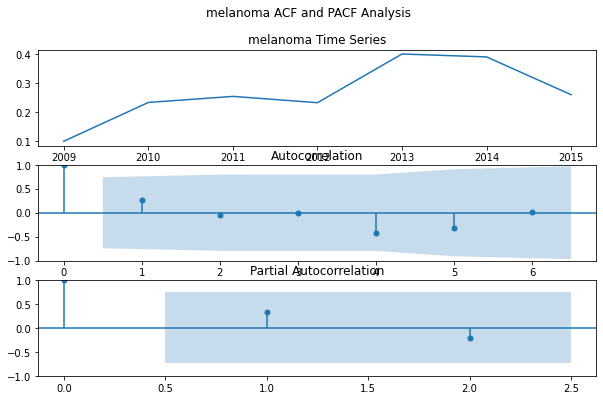

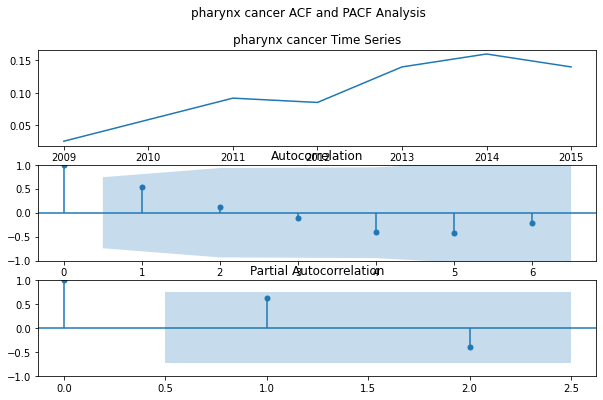

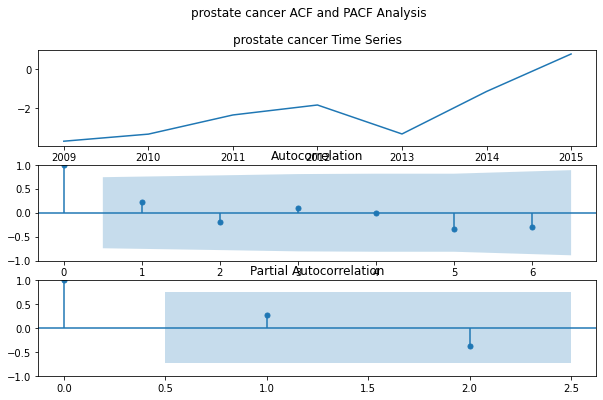

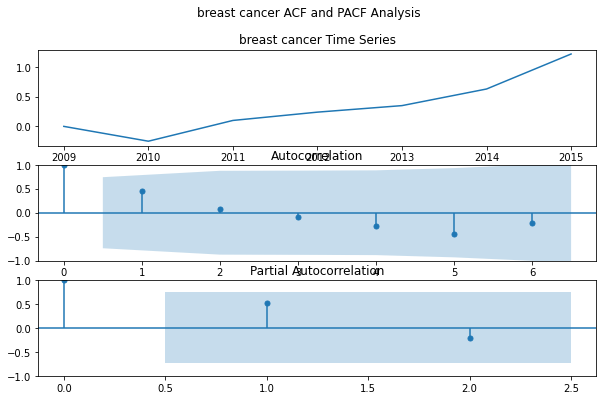

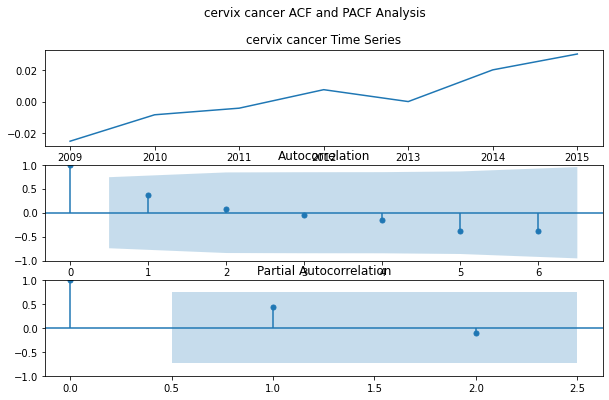

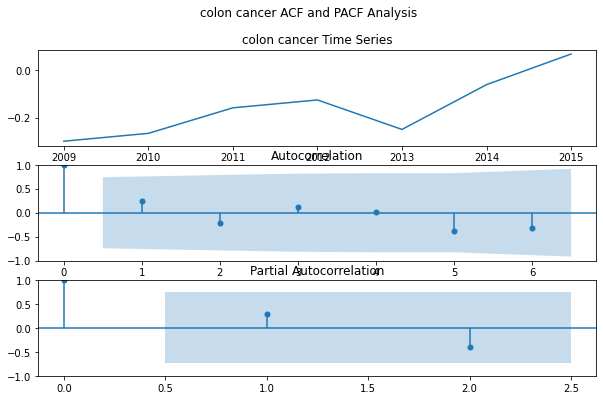

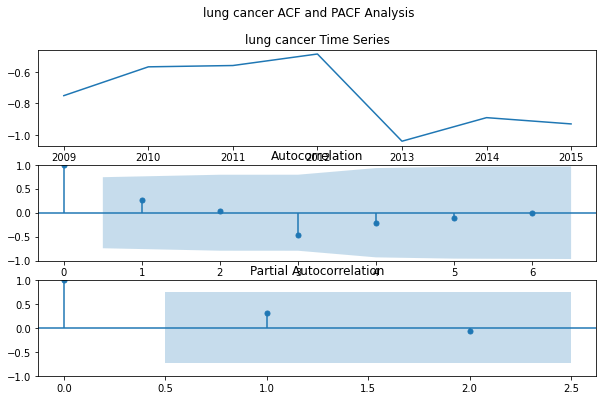

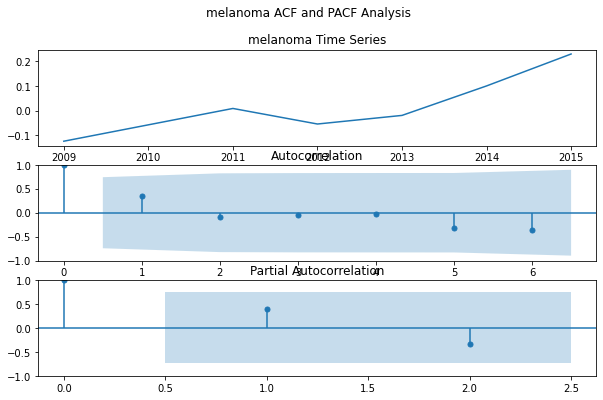

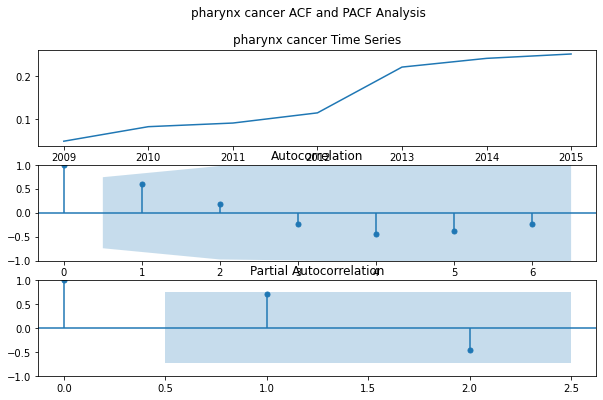

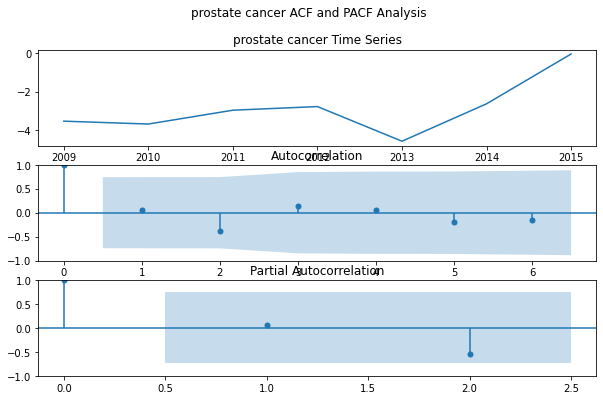

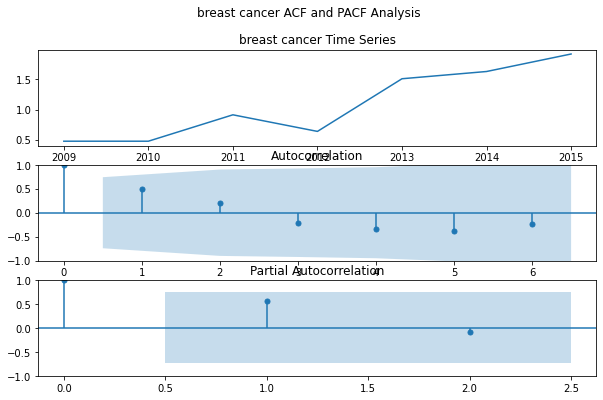

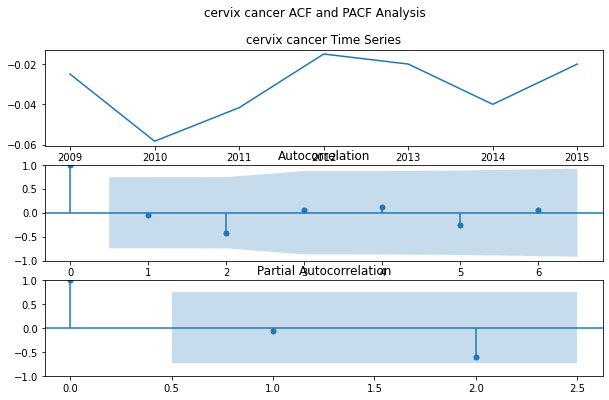

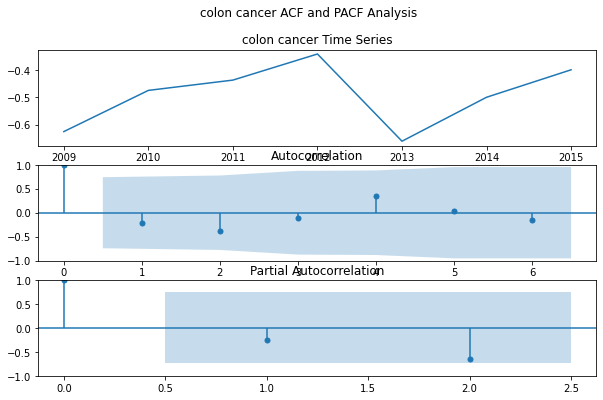

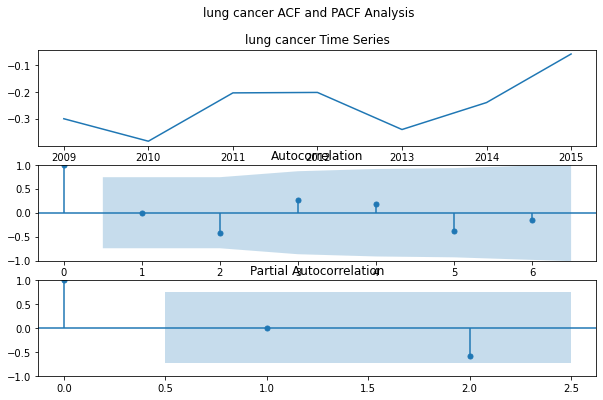

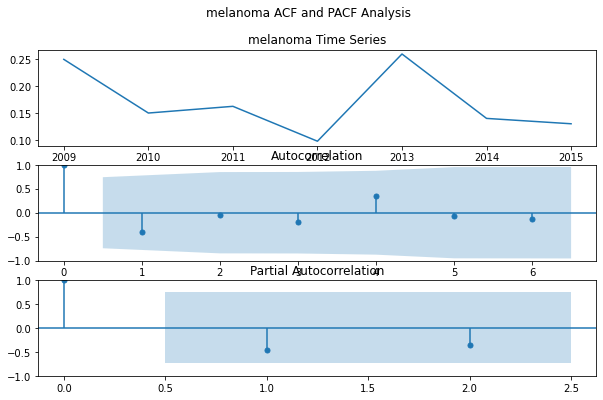

In [16]:
# Create a list of dataframes
#dfs = [cal, tex, ny]

dfs = [cal.diff().dropna(), tex.diff().dropna(), ny.diff().dropna()]

# Loop over each dataframe
for df in dfs:
    # Get the list of cancer types
    cancer_types = df.columns.tolist()
    # Loop over each cancer type
    for cancer_type in cancer_types:
        # Get the time series for the cancer type
        ts = df[cancer_type]
        # Perform ACF and PACF analysis
        fig, axes = plt.subplots(3, 1, figsize=(10, 6))
        ts.plot(ax=axes[0])
        axes[0].set_title(f"{cancer_type} Time Series")
        sm.graphics.tsa.plot_acf(ts, lags=6, ax=axes[1])
        sm.graphics.tsa.plot_pacf(ts, lags=2, ax=axes[2])
        fig.suptitle(f"{cancer_type} ACF and PACF Analysis")
        plt.show()


Next we are performing a stationarity test (KPSS) to check whether the data are in fact stationary, so they can be fitted in the ARIMA model

In [17]:
from statsmodels.tsa.stattools import kpss
# p - value of adfuller test for the returns
for i in cal.columns: 
    kpss_result = kpss(cal[i].diff().dropna())
    print('KPSS Statistic: ', kpss_result[0])
    print('p-value: ', kpss_result[1])

KPSS Statistic:  0.2255009232031646
p-value:  0.1
KPSS Statistic:  0.12741522070010633
p-value:  0.1
KPSS Statistic:  0.44768279935307215
p-value:  0.05660224165815857
KPSS Statistic:  0.3609679497503558
p-value:  0.09397933200415698
KPSS Statistic:  0.11888116840241002
p-value:  0.1
KPSS Statistic:  0.2942230622299616
p-value:  0.1
KPSS Statistic:  0.3354340098306202
p-value:  0.1


In [18]:
from statsmodels.tsa.stattools import kpss
# p - value of adfuller test for the returns
for i in tex.columns: 
    kpss_result = kpss(tex[i].diff().dropna())
    print('KPSS Statistic: ', kpss_result[0])
    print('p-value: ', kpss_result[1])

KPSS Statistic:  0.4240954401982985
p-value:  0.06676920681107824
KPSS Statistic:  0.38969212718218693
p-value:  0.0815982210421608
KPSS Statistic:  0.42182673338418947
p-value:  0.06774709767922868
KPSS Statistic:  0.455502093868727
p-value:  0.05323185609106597
KPSS Statistic:  0.3968647165678986
p-value:  0.0785065876862506
KPSS Statistic:  0.28186975642426854
p-value:  0.1
KPSS Statistic:  0.4080169802006239
p-value:  0.07369957749973109


In [19]:
from statsmodels.tsa.stattools import kpss
# p - value of adfuller test for the returns
for i in ny.columns: 
    kpss_result = kpss(ny[i].diff().dropna())
    print('KPSS Statistic: ', kpss_result[0])
    print('p-value: ', kpss_result[1])

KPSS Statistic:  0.4276075674849685
p-value:  0.06525535884268602
KPSS Statistic:  0.2897607012706365
p-value:  0.1
KPSS Statistic:  0.4322281408855904
p-value:  0.0632637323769007
KPSS Statistic:  0.16922958634476368
p-value:  0.1
KPSS Statistic:  0.1332393322787177
p-value:  0.1
KPSS Statistic:  0.29644082450994397
p-value:  0.1
KPSS Statistic:  0.4285714285714284
p-value:  0.0648399014778326


plotting the acf and pacf of the differenced data once more

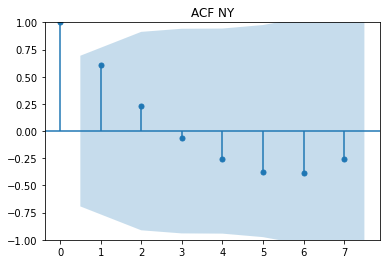

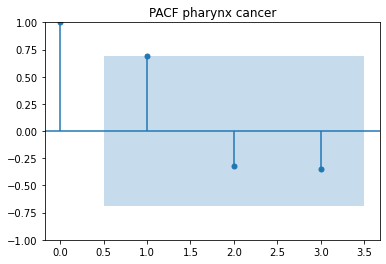

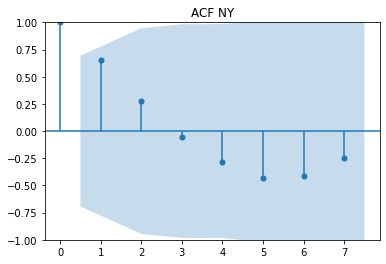

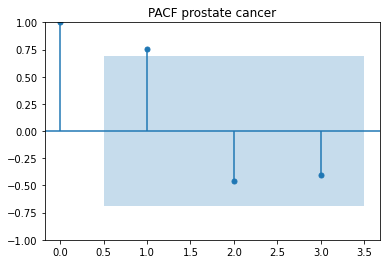

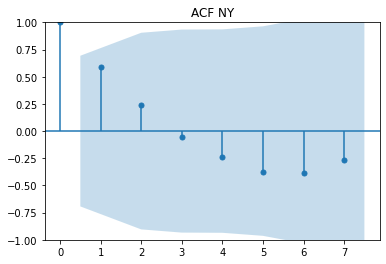

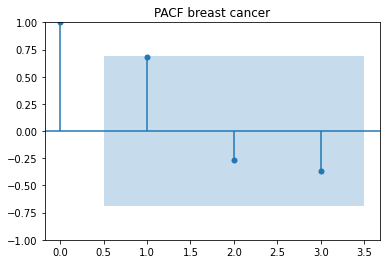

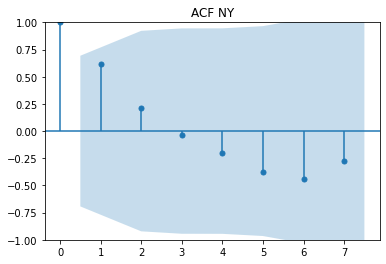

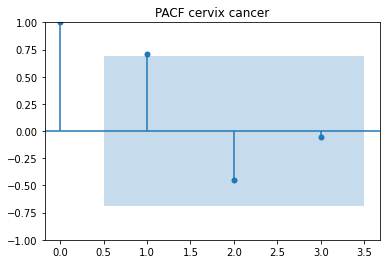

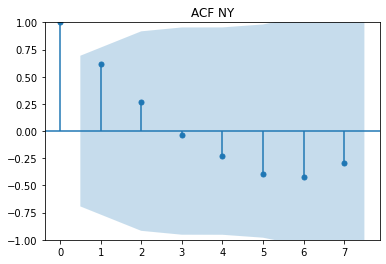

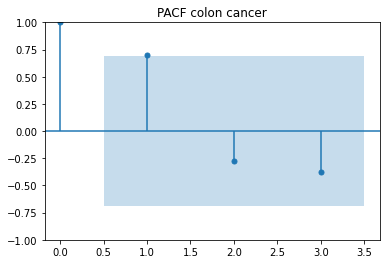

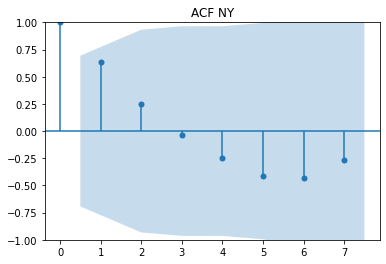

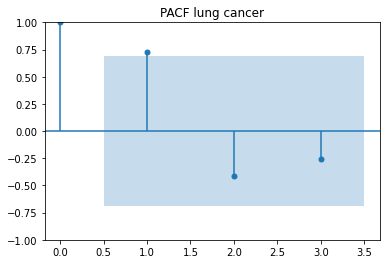

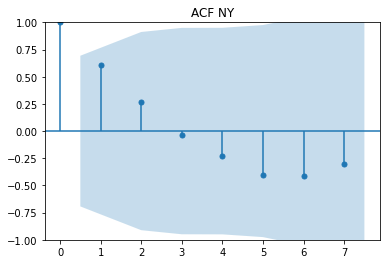

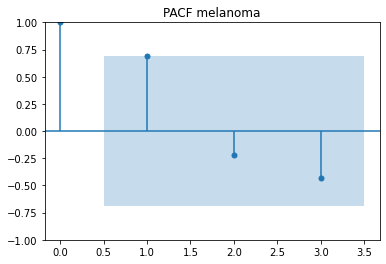

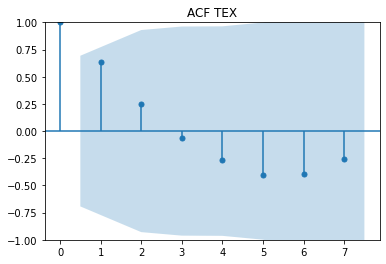

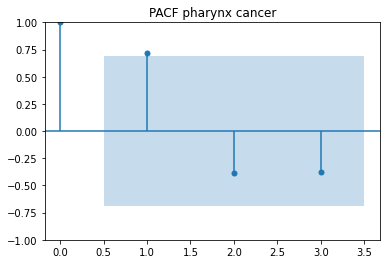

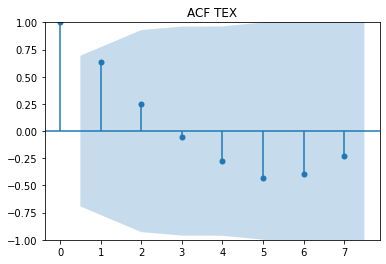

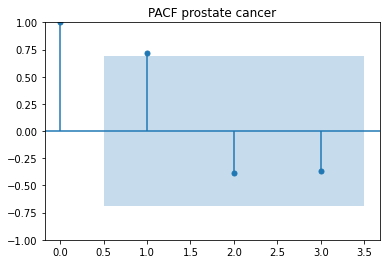

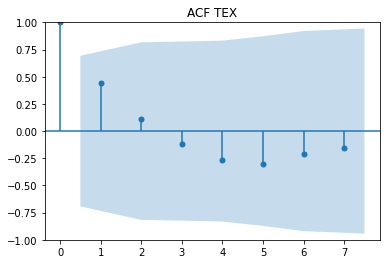

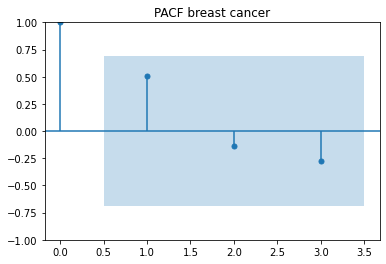

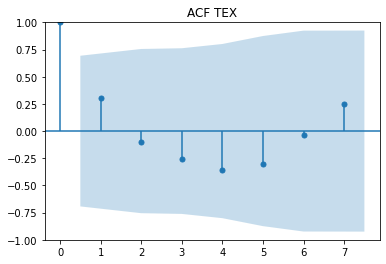

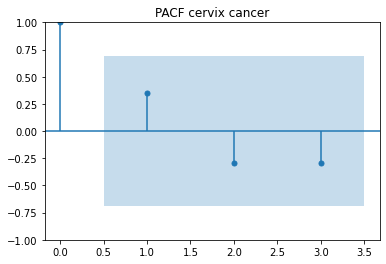

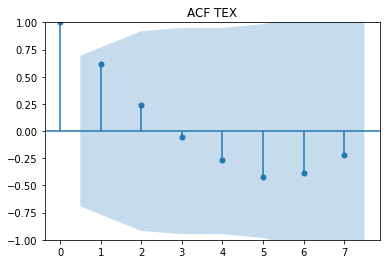

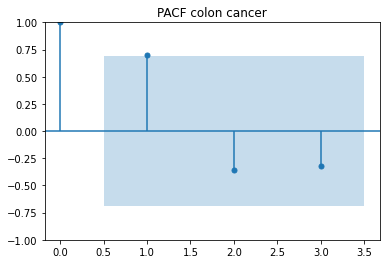

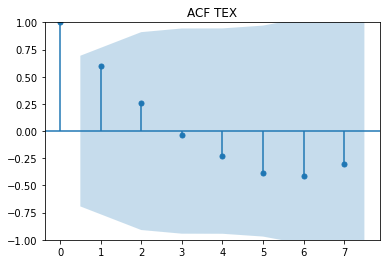

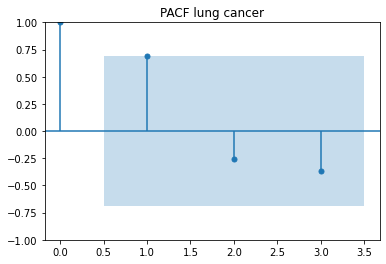

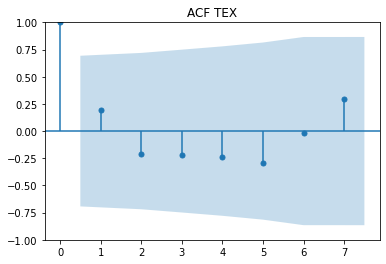

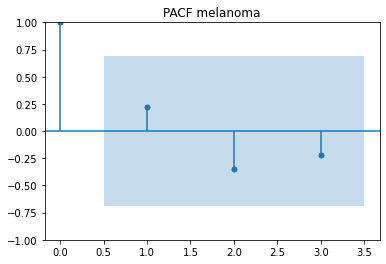

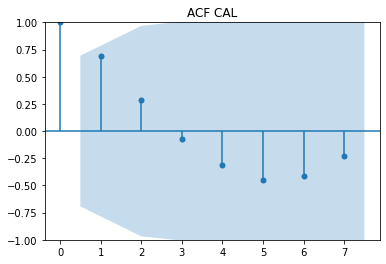

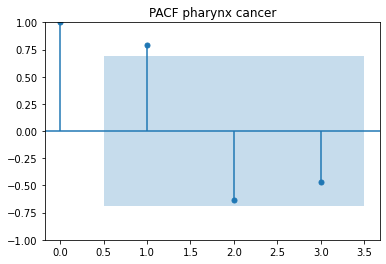

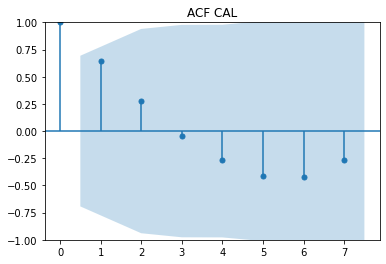

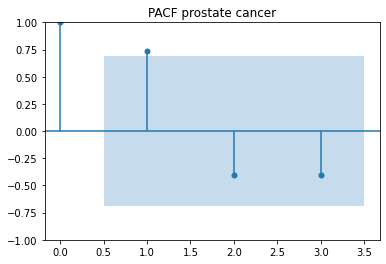

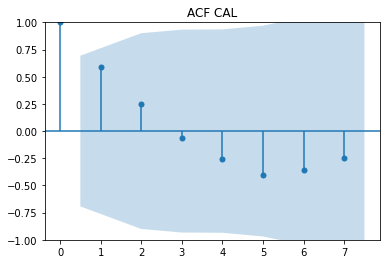

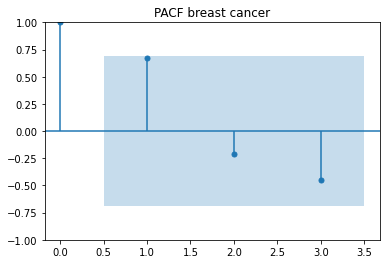

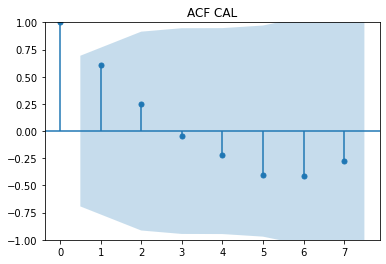

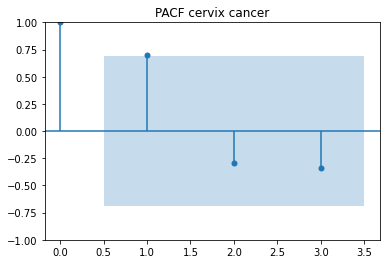

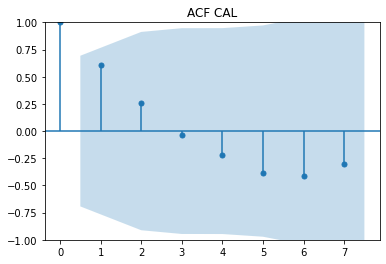

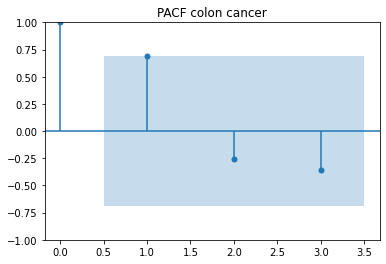

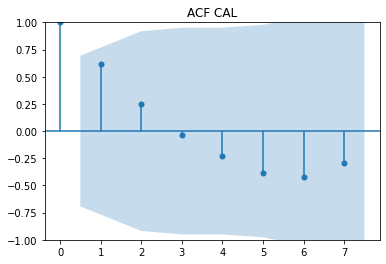

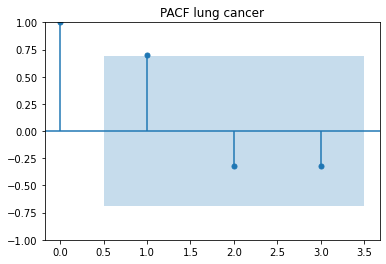

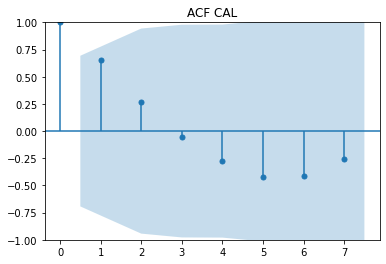

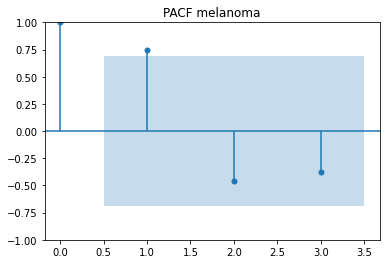

In [20]:
for j, s  in zip ([ny, tex, cal] , ['NY', 'TEX', 'CAL']):
    for i in ny.columns: 
        plot_acf(j[i], title = 'ACF {}'.format(s))
        plot_pacf(j[i], lags = 3, title ='PACF {}'.format(i))
        plt.show()

seems most of them will need an AR(1) after the differencing

We look at the plots of the differenced data above and that the trend seems to be gone. the KPSS test statistic is small, indicating a high probability of stationarity. However, the p-values are close to the chosen significance level of 0.1, suggesting that there is a possibility that the time series is not stationary. But seeing the plots and given our data, we choose a significance level of 10% or more and continue the ARIMA part

Accuracy and model selection section

In [21]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

california

In [22]:
for column in cal.columns:
    # Fit an ARIMA model using the auto_arima function
    model = auto_arima(cal[column], seasonal=False, suppress_warnings=True,d=1)
    print(f'Column: {column}, ARIMA Model: {model.order}')
    forecast = model.predict(n_periods=3)
    print(f"Predictions for \n{column}: {forecast}")
    # Get the MAE 
    print('MAE: ',np.sqrt(mean_absolute_error(cal1[column][-4:-1], forecast)))
 
    # Get the RMSE 
    print('RMSE: ',np.sqrt(mean_squared_error(cal1[column][-4:-1], forecast)))

    print('R squered: ',r2_score(cal1[column][-4:-1], forecast))

Column: pharynx cancer, ARIMA Model: (0, 1, 0)
Predictions for 
pharynx cancer: 8     10.701428
9     10.732856
10    10.764285
dtype: float64
MAE:  0.2626166235853898
RMSE:  0.07776136627279921
R squered:  -54.97636992612608
Column: prostate cancer, ARIMA Model: (0, 1, 0)
Predictions for 
prostate cancer: 8     88.19
9     84.27
10    80.35
dtype: float64
MAE:  2.4784067481628664
RMSE:  6.86424690368543
R squered:  -1860.4473305581603
Column: breast cancer, ARIMA Model: (0, 1, 0)
Predictions for 
breast cancer: 8     128.418571
9     128.727142
10    129.035713
dtype: float64
MAE:  0.4572598507940644
RMSE:  0.21340842186021733
R squered:  -0.0403442012697921
Column: cervix cancer, ARIMA Model: (0, 1, 0)
Predictions for 
cervix cancer: 8     7.247142
9     7.184285
10    7.121427
dtype: float64
MAE:  0.3462397835095187
RMSE:  0.12851714417020244
R squered:  -474.6797027551945
Column: colon cancer, ARIMA Model: (0, 1, 0)
Predictions for 
colon cancer: 8     35.577142
9     35.074285
10 

New york

In [23]:
for column in ny.columns:
    # Fit an ARIMA model using the auto_arima function
    model = auto_arima(ny[column], seasonal=False, suppress_warnings=True,d=1)
    print(f'Column: {column}, ARIMA Model: {model.order}')
    forecast = model.predict(n_periods=3)
    print(f"Predictions for \n{column}: {forecast}")
    # Get the MAE 
    print('MAE: ',np.sqrt(mean_absolute_error(ny1[column][-4:-1], forecast)))
 
    # Get the RMSE 
    print('RMSE: ',np.sqrt(mean_squared_error(ny1[column][-4:-1], forecast)))

    print('R squered: ',r2_score(ny1[column][-4:-1], forecast))

Column: pharynx cancer, ARIMA Model: (1, 1, 0)
Predictions for 
pharynx cancer: 8     12.541264
9     12.774098
10    12.998795
dtype: float64
MAE:  0.4600690693867906
RMSE:  0.22995514843777598
R squered:  -4.610451403993356
Column: prostate cancer, ARIMA Model: (0, 1, 0)
Predictions for 
prostate cancer: 8     137.172857
9     134.275714
10    131.378571
dtype: float64
MAE:  2.6295557594512973
RMSE:  7.794817534119168
R squered:  -38.609905399544395
Column: breast cancer, ARIMA Model: (1, 1, 0)
Predictions for 
breast cancer: 8     149.066529
9     150.617351
10    152.054597
dtype: float64
MAE:  1.2048711899821993
RMSE:  1.5067663508149427
R squered:  -2.3976523180009686
Column: cervix cancer, ARIMA Model: (0, 1, 0)
Predictions for 
cervix cancer: 8     8.048571
9     8.017143
10    7.985714
dtype: float64
MAE:  0.21939705306887294
RMSE:  0.04979967353451587
R squered:  -2.046530520806711
Column: colon cancer, ARIMA Model: (0, 1, 0)
Predictions for 
colon cancer: 8     41.868571
9  

Texas

In [24]:
for column in tex.columns:
    # Fit an ARIMA model using the auto_arima function
    model = auto_arima(tex[column], seasonal=False, suppress_warnings=True,d=1)
    print(f'Column: {column}, ARIMA Model: {model.order}')
    forecast = model.predict(n_periods=3)
    print(f"Predictions for \n{column}: {forecast}")
    # Get the MAE 
    print('MAE: ',np.sqrt(mean_absolute_error(tex1[column][-4:-1], forecast)))
 
    # Get the RMSE 
    print('RMSE: ',np.sqrt(mean_squared_error(tex1[column][-4:-1], forecast)))

    print('R squered: ',r2_score(tex1[column][-4:-1], forecast))

Column: pharynx cancer, ARIMA Model: (1, 1, 0)
Predictions for 
pharynx cancer: 8     11.433083
9     11.559591
10    11.679848
dtype: float64
MAE:  0.37343252695501866
RMSE:  0.14985785117359804
R squered:  -9.641593683234298
Column: prostate cancer, ARIMA Model: (0, 1, 1)
Predictions for 
prostate cancer: 8     95.524963
9     93.373768
10    91.222574
dtype: float64
MAE:  2.2775739097078294
RMSE:  6.004102738204435
R squered:  -21.39319938237522
Column: breast cancer, ARIMA Model: (1, 1, 0)
Predictions for 
breast cancer: 8     118.385810
9     119.370072
10    120.254141
dtype: float64
MAE:  0.9162162464833236
RMSE:  0.862513626897931
R squered:  -1.1772570446991515
Column: cervix cancer, ARIMA Model: (0, 1, 0)
Predictions for 
cervix cancer: 8     9.27
9     9.27
10    9.27
dtype: float64
MAE:  0.18484227510682447
RMSE:  0.037555514464146005
R squered:  -4.802857142857385
Column: colon cancer, ARIMA Model: (0, 1, 1)
Predictions for 
colon cancer: 8     37.667025
9     37.508554
10

Simple Exponential Smoothing (to try as an alternative basis model)

In [25]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Loop over each column in the DataFrame
for column in cal.columns:
    # Get the time series data for the column
    ts = cal[column]
    
    # Find the optimal alpha value
    mse_list = []
    for alpha in range(1, 10):
        alpha_value = alpha/10.0
        model = SimpleExpSmoothing(ts).fit(smoothing_level=alpha_value)
        y_pred = model.forecast(steps=3)
        mse = mean_squared_error(cal1[column][-4:-1], y_pred)
        mse_list.append(mse)
    optimal_alpha = (mse_list.index(min(mse_list)) + 1)/10.0
    
    # Perform simple exponential smoothing with the optimal alpha value
    model = SimpleExpSmoothing(ts).fit(smoothing_level=optimal_alpha)
    y_pred = model.forecast(steps=3)
    mse = mean_squared_error(cal1[column][-4:-1], y_pred)
    Rsquared = r2_score(cal1[column][-4:-1], forecast)
    
    # Print the forecast and mean squared error for the column
    print(f"Column: {column}")
    print(f"Optimal alpha: {optimal_alpha}")
    print(f"Forecast: {y_pred}")
    print(f"Mean squared error: {mse}")
    print(f"R squared: {Rsquared}")

Column: pharynx cancer
Optimal alpha: 0.8
Forecast: 8     10.663929
9     10.663929
10    10.663929
dtype: float64
Mean squared error: 0.00010802626339350288
R squared: -63356.23142857088
Column: prostate cancer
Optimal alpha: 0.9
Forecast: 8     92.435233
9     92.435233
10    92.435233
dtype: float64
Mean squared error: 4.116762841571113
R squared: -235038.9158024612
Column: breast cancer
Optimal alpha: 0.9
Forecast: 8     128.039264
9     128.039264
10    128.039264
dtype: float64
Mean squared error: 0.2730183406391845
R squared: -303351.24781702406
Column: cervix cancer
Optimal alpha: 0.9
Forecast: 8     7.312594
9     7.312594
10    7.312594
dtype: float64
Mean squared error: 0.00010573812243314931
R squared: -1028464.8200001165
Column: colon cancer
Optimal alpha: 0.9
Forecast: 8     36.127756
9     36.127756
10    36.127756
dtype: float64
Mean squared error: 0.19150026709299026
R squared: -26398.271803277836
Column: lung cancer
Optimal alpha: 0.9
Forecast: 8     42.756669
9     4

In [27]:
# Loop over each column in the DataFrame
for column in ny.columns:
    # Get the time series data for the column
    ts = ny[column]
    
    # Find the optimal alpha value
    mse_list = []
    for alpha in range(1, 10):
        alpha_value = alpha/10.0
        model = SimpleExpSmoothing(ts).fit(smoothing_level=alpha_value)
        y_pred = model.forecast(steps=3)
        mse = mean_squared_error(ny1[column][-4:-1], y_pred)
        mse_list.append(mse)
    optimal_alpha = (mse_list.index(min(mse_list)) + 1)/10.0
    
    # Perform simple exponential smoothing with the optimal alpha value
    model = SimpleExpSmoothing(ts).fit(smoothing_level=optimal_alpha)
    y_pred = model.forecast(steps=3)
    mse = mean_squared_error(ny1[column][-4:-1], y_pred)
    Rsquared = r2_score(ny1[column][-4:-1], forecast)
    
    # Print the forecast and mean squared error for the column
    print(f"Column: {column}")
    print(f"Optimal alpha: {optimal_alpha}")
    print(f"Forecast: {y_pred}")
    print(f"Mean squared error: {mse}")
    print(f"R squared: {Rsquared}")

Column: pharynx cancer
Optimal alpha: 0.9
Forecast: 8     12.272367
9     12.272367
10    12.272367
dtype: float64
Mean squared error: 0.09199789354381392
R squared: -55.044199754399756
Column: prostate cancer
Optimal alpha: 0.6
Forecast: 8     140.920004
9     140.920004
10    140.920004
dtype: float64
Mean squared error: 1.606987062850888
R squared: -10666.029548965274
Column: breast cancer
Optimal alpha: 0.9
Forecast: 8     147.150117
9     147.150117
10    147.150117
dtype: float64
Mean squared error: 4.579353598638293
R squared: -27617.99754087758
Column: cervix cancer
Optimal alpha: 0.9
Forecast: 8     8.082422
9     8.082422
10    8.082422
dtype: float64
Mean squared error: 0.0011079667929199003
R squared: -33405.26341232214
Column: colon cancer
Optimal alpha: 0.9
Forecast: 8     42.405699
9     42.405699
10    42.405699
dtype: float64
Mean squared error: 0.12883651197876597
R squared: -49631.32644490628
Column: lung cancer
Optimal alpha: 0.9
Forecast: 8     65.178763
9     65.1

Simple exponential smoothing seems to predict the same for each future period and so we discard it!!!!

We move on to perform the ARIMA and create a dataframe to compare against the next model

We create a dataframe for the results of the baseline model to be inserted into along with a metric for accuracy

In [28]:
#initialize the results dataframe
results_df = pd.DataFrame(columns=['Year', 'State', 'Cancer', 'Accuracy'])

We perform Auto Arima to get the order of the model for each state and each cancer. This evaluates many different in order models and chooses the one with the smallest AIC value (we do that for each cancer and for each state)

In [29]:
# Loop through each state and cancer type
for i, j, state in zip([ny, tex, cal], [ny1, tex1, cal1], ['NY', 'TEX', 'CAL']):
    for column in i.columns:
        # Fit an ARIMA model using the auto_arima function
        model = auto_arima(i[column], seasonal=False, error_action="ignore",d=1)
        forecast = model.predict(n_periods=3)
        
        # Calculate the mean squared error for each forecast period
        mse = []
        for k in range(0, 3):
            mse.append((j[column].iloc[-(k+2)] - forecast.iloc[k])**2)
            results_df = results_df.append({'Year': int(2016+k),'State': state, 'Cancer': column, 'Accuracy': mse[k]}, ignore_index=True)

# Reshape the results dataframe
#results_df = results_df.pivot_table(index=['Year', 'Cancer', 'State'], values='Accuracy', aggfunc='mean').reset_index()


In [30]:
results_df = results_df.sort_values(by=['State','Cancer','Year'], ascending=True)

In [31]:
forecast #for the last cancer (melanoma) (for california this one)

8     21.914994
9     22.168548
10    22.422101
dtype: float64

In [32]:
results_df

,Year,State,Cancer,Accuracy
48,2016,CAL,breast cancer,0.127042
49,2017,CAL,breast cancer,0.044300
50,2018,CAL,breast cancer,0.597859
51,2016,CAL,cervix cancer,0.002794
52,2017,CAL,cervix cancer,0.013390
...,...,...,...,...
22,2017,TEX,pharynx cancer,0.020427
23,2018,TEX,pharynx cancer,0.100710
24,2016,TEX,prostate cancer,21.622849
25,2017,TEX,prostate cancer,25.599199


We are taking the MSE to check against the original model

In [33]:
#cancer_map = {
#    'pharynx cancer': 'CAN10_1',
#    'prostate cancer': 'CAN11_1',
#    'breast cancer': 'CAN5_1',
#    'cervix cancer': 'CAN6_1',
#    'colon cancer': 'CAN7_1',
#    'lung cancer': 'CAN8_1',
 #   'melanoma': 'CAN9_1'
#}

# Rename the rows using the reverse_column_map dictionary
#results_df['Cancer'] = results_df['Cancer'].replace(cancer_map)
#results_df

In [34]:
#results_df.to_csv("BasisModelAcc.csv", index=False)

Our predictions were not too bad, the data was fed in the original form and used the differencing in the auto arima to get the results. Now we have to see if they are good enough using his metric (MSE)